Load the dataset

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

def load_data(file_path):
    df = pd.read_csv(file_path)
    bands = [col for col in df.columns if any(col.startswith(f"{month}_B") for month in 
            ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])]

    X = df[bands].values
    
    label_mapping = {
        'A10': 1, 'A11': 1, 'A12': 1, 'A13': 1, 'A20': 1, 'A21': 1, 'A30': 1,
        'A22': 2, 'F10': 2, 'F20': 2, 'F30': 2, 'F40': 2,
        'E10': 3, 'E20': 3, 'E30': 3, 'B50': 3, 'B51': 3, 'B52': 3, 'B53': 3,
        'B54': 3, 'B55': 3,
        'B10': 4, 'B11': 4, 'B12': 4, 'B13': 4, 'B14': 4, 'B15': 4, 'B16': 4,
        'B17': 4, 'B18': 4, 'B19': 4, 'B20': 4, 'B21': 4, 'B22': 4, 'B23': 4,
        'B30': 4, 'B31': 4, 'B32': 4, 'B33': 4, 'B34': 4, 'B35': 4, 'B36': 4,
        'B37': 4, 'B40': 4, 'B41': 4, 'B42': 4, 'B43': 4, 'B44': 4, 'B45': 4,
        'B70': 4, 'B71': 4, 'B72': 4, 'B73': 4, 'B74': 4, 'B75': 4, 'B76': 4,
        'B77': 4, 'B80': 4, 'B81': 4, 'B82': 4, 'B83': 4, 'B84': 4, 'BX1': 4,
        'BX2': 4, 'C10': 5, 'C20': 6, 'C21': 6, 'C22': 6, 'C23': 6, 'C30': 6,
        'C31': 6, 'C32': 6, 'C33': 6, 'CXX1': 6, 'CXX2': 6, 'CXX3': 6,
        'CXX4': 6, 'CXX5': 6, 'CXX6': 6, 'CXX7': 6, 'CXX8': 6, 'CXX9': 6,
        'CXXA': 6, 'CXXB': 6, 'CXXC': 6, 'CXXD': 6, 'CXXE': 6, 'D10': 7,
        'D20': 7, 'G10': 8, 'G11': 8, 'G12': 8, 'G20': 8, 'G21': 8, 'G22': 8,
        'G30': 8, 'G40': 8, 'G50': 8, 'H10': 9, 'H11': 9, 'H12': 9, 'H20': 9,
        'H21': 9, 'H22': 9, 'H23': 9
    }
    y = df['Lc1'].map(label_mapping).values
    return X, y

# Load train and test data
X_train, y_train = load_data('uk_monthly_train_adj_norm.csv')
X_test, y_test = load_data('uk_monthly_test_adj_norm.csv')

### Random Forest

GridSearchCV

In [4]:
# GridSearchCV Hyperparameter tuning for Random Forest Classifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


Bayesian Optimisation (Optuna)

In [7]:
# Bayesian Optimization with Optuna Hyperparameter tuning for Random Forest Classifier
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 5, 50),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return f1_score(y_test, y_pred, average='macro')

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)

[I 2025-04-04 12:52:56,189] A new study created in memory with name: no-name-3cdd24ee-c04b-4bd4-a735-c97f59d15ba4
[I 2025-04-04 12:52:58,811] Trial 0 finished with value: 0.4441639268681749 and parameters: {'n_estimators': 393, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.4441639268681749.
[I 2025-04-04 12:53:00,666] Trial 1 finished with value: 0.43826164820020375 and parameters: {'n_estimators': 292, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.4441639268681749.
[I 2025-04-04 12:53:02,810] Trial 2 finished with value: 0.4382025697509887 and parameters: {'n_estimators': 348, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.4441639268681749.
[I 2025-04-04 12:53:06,021] Trial 3 finished with value: 0.43320581604189784 and parameters: {'n_estimators': 464, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 0 with va

Best parameters: {'n_estimators': 439, 'max_depth': 34, 'min_samples_split': 6, 'min_samples_leaf': 1}


In [8]:
optuna_rf = RandomForestClassifier(
    n_estimators=439,
    max_depth=34,
    min_samples_split=6,
    min_samples_leaf=1,
    random_state=42
)
optuna_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=34, min_samples_split=6, n_estimators=439,
                       random_state=42)

### SVM

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Load Data (Assuming X_train, X_test, y_train, y_test are available)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Kernel coefficient
    'kernel': ['rbf', 'poly'],  # Try different kernels
    'class_weight': ['balanced', None]  # Address class imbalance
}

# Initialize SVM and GridSearch
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Predict using the best model
best_svm = grid_search.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)


# Evaluation
accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

In [18]:
# Bayesian Optimization with Optuna Hyperparameter tuning for SVM
from sklearn.svm import SVC
from sklearn.metrics import f1_score
def objective(trial):
    C = trial.suggest_loguniform("C", 1e-2, 1e2)
    gamma = trial.suggest_loguniform("gamma", 1e-4, 1e0)
    kernel = trial.suggest_categorical("kernel", ["rbf", "poly"])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    
    model = SVC(C=C, gamma=gamma, kernel=kernel, class_weight=class_weight, random_state=42)
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)  # or use cross_val_score
    return f1_score(y_test, y_pred, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-04-04 13:12:12,959] A new study created in memory with name: no-name-82609073-f616-4a18-a080-f6c0ab0c8c9f
/var/folders/z5/zqtg1_hn7_x7fpg92yxfn09r0000gn/T/ipykernel_5069/3831025733.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-2, 1e2)
/var/folders/z5/zqtg1_hn7_x7fpg92yxfn09r0000gn/T/ipykernel_5069/3831025733.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform("gamma", 1e-4, 1e0)
[I 2025-04-04 13:12:40,382] Trial 0 finished with value: 0.07253166753427034 and parameters: {'C': 0.018822461805415313, 'gamma': 0.0739153673611347, 'kernel': 'rbf', 'class_weight': None}. Best is trial 0 with v

In [30]:
best_svm_optuna = SVC(
    C=22.90420869178104,
    gamma=0.00041822818832112116,
    kernel='rbf',
    class_weight=None,
    random_state=42
)
best_svm_optuna.fit(X_train_scaled, y_train)

SVC(C=22.90420869178104, gamma=0.00041822818832112116, random_state=42)

### XGB

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import GridSearchCV

# Remap label 9 to 0 (xgbclassifier requires labels to start from 0, not 1)
y_train = np.where(y_train == 9, 0, y_train)
y_test = np.where(y_test == 9, 0, y_test)

# Define XGBoost classifier
xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=9, eval_metric="mlogloss", use_label_encoder=False)

# Define the parameter grid
param_grid = {
    "n_estimators": [50, 100, 200], 
    "max_depth": [3, 5, 7], 
    "learning_rate": [0.01, 0.1, 0.2],  
    "subsample": [0.8, 1.0],  
    "colsample_bytree": [0.8, 1.0]
}

# Set up GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               scoring="accuracy", cv=3, verbose=2, n_jobs=-1)

# Run Grid Search
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters
print("Best Parameters:", grid_search_xgb.best_params_)

# Train best model
best_xgb = grid_search_xgb.best_estimator_

# Make predictions
y_pred_xgb = best_xgb.predict(X_test)

# Convert predicted label 0 back to 9 for consistency
y_pred_xgb = np.where(y_pred_xgb == 0, 9, y_pred_xgb)
# Ensure y_test is also converted back for proper evaluation
y_test = np.where(y_test == 0, 9, y_test)

In [27]:
import optuna
from sklearn.metrics import f1_score
import xgboost as xgb

def objective(trial):
    params = {
        "objective": "multi:softmax",
        "num_class": 9,
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "n_jobs": -1
    }

    model = xgb.XGBClassifier(**params)

    # Remap label 9 to 0 for XGBoost
    y_train_remapped = np.where(y_train == 9, 0, y_train)
    y_test_remapped = np.where(y_test == 9, 0, y_test)

    model.fit(X_train, y_train_remapped)
    preds = model.predict(X_test)
    
    # Convert predictions back to original labels for evaluation
    preds = np.where(preds == 0, 9, preds)
    y_test_true = np.where(y_test_remapped == 0, 9, y_test_remapped)

    return f1_score(y_test_true, preds, average='macro')

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2025-04-04 13:32:32,096] A new study created in memory with name: no-name-2f688a86-7c9f-456f-8b82-18fac6108d67
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:32:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-04 13:32:38,049] Trial 0 finished with value: 0.5076725357831458 and parameters: {'n_estimators': 190, 'max_depth': 15, 'learning_rate': 0.1444996987267621, 'subsample': 0.7267227842592255, 'colsample_bytree': 0.91601247491713, 'gamma': 2.2693747495750105, 'min_child_weight': 1}. Best is trial 0 with value: 0.5076725357831458.
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:32:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-04-04 13:32:44,444] Trial 1 finished

In [34]:
best_xgb = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=9,
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=438,
    max_depth=3,
    learning_rate=0.2155121784596623,
    subsample=0.7616832743549153,
    colsample_bytree=0.8483548247399473,
    gamma=0.9334204872821765,
    min_child_weight=8,
    random_state=42,
    n_jobs=-1
)

# Train on remapped labels
y_train_remap = np.where(y_train == 9, 0, y_train)
best_xgb.fit(X_train, y_train_remap)

/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [13:48:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8483548247399473, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.9334204872821765, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2155121784596623,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=438, n_jobs=-1, num_class=9,
              num_parallel_tree=None, ...)

### Evaluation with Validation Data

In [21]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    
    # Extract bands for features
    bands = [col for col in df.columns if any(col.startswith(f"{month}_B") for month in 
            ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])]
    
    # Label mapping
    label_mapping = {
        'A10': 1, 'A11': 1, 'A12': 1, 'A13': 1, 'A20': 1, 'A21': 1, 'A30': 1,
        'A22': 2, 'F10': 2, 'F20': 2, 'F30': 2, 'F40': 2,
        'E10': 3, 'E20': 3, 'E30': 3, 'B50': 3, 'B51': 3, 'B52': 3, 'B53': 3,
        'B54': 3, 'B55': 3,
        'B10': 4, 'B11': 4, 'B12': 4, 'B13': 4, 'B14': 4, 'B15': 4, 'B16': 4,
        'B17': 4, 'B18': 4, 'B19': 4, 'B20': 4, 'B21': 4, 'B22': 4, 'B23': 4,
        'B30': 4, 'B31': 4, 'B32': 4, 'B33': 4, 'B34': 4, 'B35': 4, 'B36': 4,
        'B37': 4, 'B40': 4, 'B41': 4, 'B42': 4, 'B43': 4, 'B44': 4, 'B45': 4,
        'B70': 4, 'B71': 4, 'B72': 4, 'B73': 4, 'B74': 4, 'B75': 4, 'B76': 4,
        'B77': 4, 'B80': 4, 'B81': 4, 'B82': 4, 'B83': 4, 'B84': 4, 'BX1': 4,
        'BX2': 4, 'C10': 5, 'C20': 6, 'C21': 6, 'C22': 6, 'C23': 6, 'C30': 6,
        'C31': 6, 'C32': 6, 'C33': 6, 'CXX1': 6, 'CXX2': 6, 'CXX3': 6,
        'CXX4': 6, 'CXX5': 6, 'CXX6': 6, 'CXX7': 6, 'CXX8': 6, 'CXX9': 6,
        'CXXA': 6, 'CXXB': 6, 'CXXC': 6, 'CXXD': 6, 'CXXE': 6, 'D10': 7,
        'D20': 7, 'G10': 8, 'G11': 8, 'G12': 8, 'G20': 8, 'G21': 8, 'G22': 8,
        'G30': 8, 'G40': 8, 'G50': 8, 'H10': 9, 'H11': 9, 'H12': 9, 'H20': 9,
        'H21': 9, 'H22': 9, 'H23': 9
    }

    X = df[bands].values
    y = df['Lc1'].map(label_mapping).values
    lucas_ids = df['Lucas_ID']  # Extract Lucas_ID column

    return X, y, lucas_ids

# Load validation data
X_val, y_val, lucas_ids = load_data('uk_monthly_val_adj_norm.csv')

In [12]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(y_true, y_pred, model_name):
    print(f"\n🔍 {model_name} Evaluation:\n")
    print(classification_report(y_true, y_pred, digits=3))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

RF

In [38]:
rf_val_pred = optuna_rf.predict(X_val)

evaluate_model(y_val, rf_val_pred, "Optuna Random Forest")


🔍 Optuna Random Forest Evaluation:

              precision    recall  f1-score   support

           1      0.559     0.563     0.561       135
           2      0.562     0.093     0.160       193
           3      0.714     0.925     0.806      1247
           4      0.732     0.764     0.748       462
           5      0.665     0.500     0.571       234
           6      0.699     0.533     0.605       135
           7      0.800     0.183     0.298       131
           8      0.923     0.545     0.686        22
           9      0.000     0.000     0.000        29

    accuracy                          0.706      2588
   macro avg      0.628     0.456     0.493      2588
weighted avg      0.691     0.706     0.667      2588

Confusion Matrix:
[[  76    4   46    8    1    0    0    0    0]
 [  36   18   58   77    1    2    1    0    0]
 [  14    1 1154   38   24   12    4    0    0]
 [   2    7   96  353    4    0    0    0    0]
 [   2    0   98    4  117   13    0    0    0]


/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)     
X_val_scaled = scaler.transform(X_val)

svm_val_pred = best_svm_optuna.predict(X_val_scaled)
evaluate_model(y_val, svm_val_pred, "Optuna SVM")


🔍 Optuna SVM Evaluation:

              precision    recall  f1-score   support

           0      0.000     0.000     0.000         0
           1      0.579     0.681     0.626       135
           2      0.435     0.140     0.212       193
           3      0.742     0.899     0.813      1247
           4      0.750     0.818     0.783       462
           5      0.634     0.547     0.587       234
           6      0.705     0.548     0.617       135
           7      0.552     0.122     0.200       131
           8      0.667     0.455     0.541        22
           9      0.000     0.000     0.000        29

    accuracy                          0.713      2588
   macro avg      0.506     0.421     0.438      2588
weighted avg      0.682     0.713     0.680      2588

Confusion Matrix:
[[   0    0    0    0    0    0    0    0    0    0]
 [   0   92    6   28    7    2    0    0    0    0]
 [   0   35   27   46   79    2    4    0    0    0]
 [   0   21    7 1121   37   32   17 

/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/senmap/

XGB

In [36]:
# Predict and remap
y_val_remap = np.where(y_val == 9, 0, y_val)
xgb_val_preds = best_xgb.predict(X_val)
xgb_val_preds = np.where(xgb_val_preds == 0, 9, xgb_val_preds)
y_val_orig = np.where(y_val_remap == 0, 9, y_val_remap)

evaluate_model(y_val_orig, xgb_val_preds, "XGBoost")


🔍 XGBoost Evaluation:

              precision    recall  f1-score   support

           1      0.604     0.644     0.624       135
           2      0.400     0.228     0.290       193
           3      0.763     0.896     0.824      1247
           4      0.765     0.766     0.765       462
           5      0.610     0.547     0.577       234
           6      0.718     0.548     0.622       135
           7      0.611     0.336     0.433       131
           8      0.833     0.682     0.750        22
           9      0.200     0.034     0.059        29

    accuracy                          0.720      2588
   macro avg      0.612     0.520     0.549      2588
weighted avg      0.699     0.720     0.702      2588

Confusion Matrix:
[[  87   19   22    2    5    0    0    0    0]
 [  30   44   49   62    4    2    2    0    0]
 [  17    9 1117   38   27   14   21    1    3]
 [   2   34   69  354    3    0    0    0    0]
 [   4    1   82    4  128   13    2    0    0]
 [   1    0  

Save all predictions to CSV

In [39]:
# Save predictions to CSV
predictions_df = pd.DataFrame({
    "Lucas_ID": lucas_ids,
    "True_Label": y_val,
    "RF_Prediction": rf_val_pred,
    "SVM_Prediction": svm_val_pred,
    "XGB_Prediction": xgb_val_preds
})

predictions_df.to_csv("adj_predictions.csv", index=False)

print("✅ Predictions saved to adj_predictions.csv")

✅ Predictions saved to adj_predictions.csv


### Visualisations

Permutation Feature Importance

/opt/anaconda3/envs/senmap/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


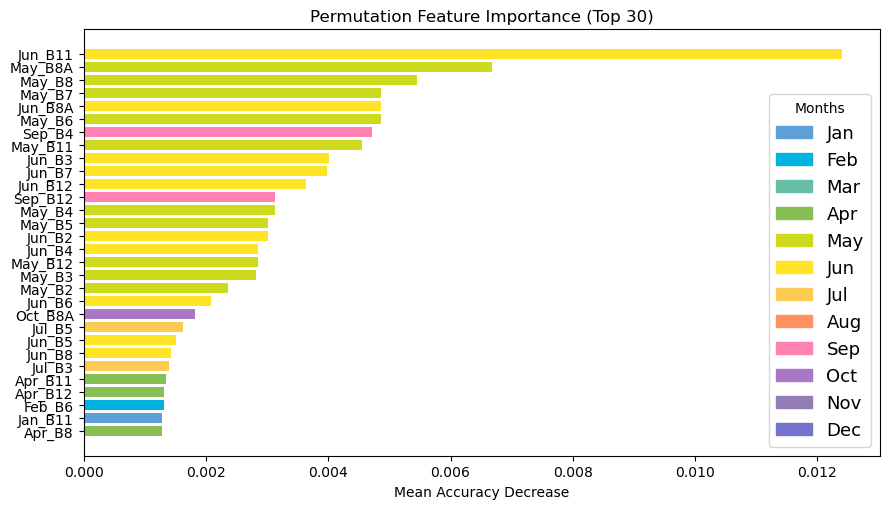

In [51]:
# result.importances_mean gives the average drop in accuracy per feature
# result.importances_std gives uncertainty across permutations
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

# Permutation Importance
# Visualise top features
result = permutation_importance(optuna_rf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)

df = pd.read_csv("uk_monthly_train_adj_norm.csv")
feature_names = df.columns.tolist()  # Get all feature columns
# Extract Sentinel-2 bands (including neighbor features like _n1 to _n10)
band_features = [col for col in feature_names if any(col.startswith(f"{month}_B") for month in 
                 ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])]

month_colors = {
    "Jan": "#5da0d7",  
    "Feb": "#00b3e1",  
    "Mar": "#65bda5",  
    "Apr": "#87bf54",  
    "May": "#ceda1e",  
    "Jun": "#fee327",  
    "Jul": "#fdca54",  
    "Aug": "#ff9160",  
    "Sep": "#fe81b1",  
    "Oct": "#aa76c6",  
    "Nov": "#927db6",  
    "Dec": "#7473cd",  
}

feature_names = np.array(band_features)
sorted_idx = result.importances_mean.argsort()[::-1][:30]  # Top 30
top_feature_names = feature_names[sorted_idx]

# Extract month names from feature names
month_labels = [name.split('_')[0] for name in top_feature_names]
# Create color list based on month
bar_colors = [month_colors.get(month, "#000000") for month in month_labels] 

plt.figure(figsize=(9, 5.2))
plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx], color=bar_colors)
plt.xlabel("Mean Accuracy Decrease")
plt.title("Permutation Feature Importance (Top 30)")
plt.gca().invert_yaxis()

handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in month_colors.values()]
labels = list(month_colors.keys())
plt.legend(handles, labels, title="Months", loc='lower right', prop={'size': 13})

plt.tight_layout()
plt.show()

Confusion Matrices for Optuna-tuned Models

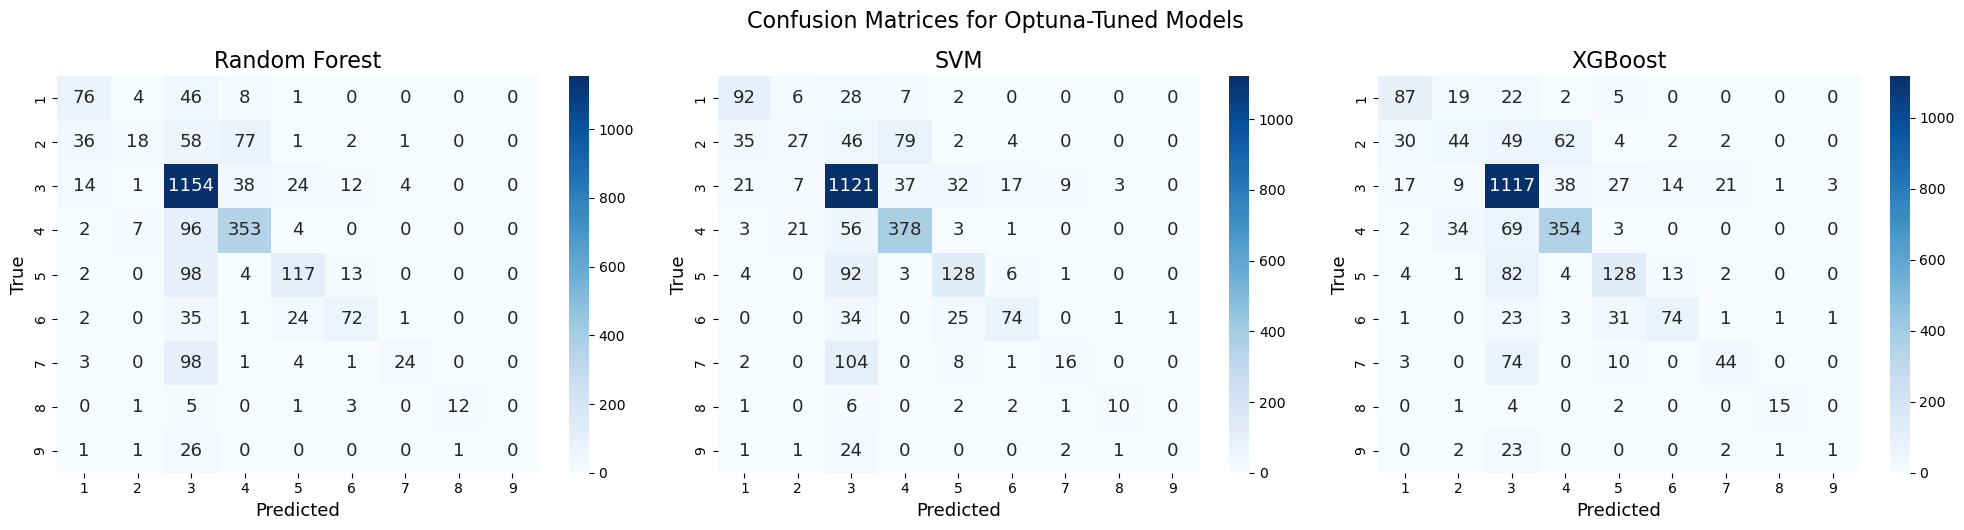

In [52]:
# Plot Confusion Matrices
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

labels = sorted(np.unique(y_val))  # Should be [1, 2, ..., 9]

# RF
rf_preds = optuna_rf.predict(X_val)
cm_rf = confusion_matrix(y_val, rf_preds)

# SVM
svm_preds = best_svm_optuna.predict(X_val_scaled)
svm_preds = svm_preds.astype(int)
svm_preds = np.where(svm_preds == 0, 9, svm_preds)

cm_svm = confusion_matrix(y_val, svm_preds)

# XGB
y_val_remap = np.where(y_val == 9, 0, y_val)
xgb_preds = best_xgb.predict(X_val)
xgb_preds = np.where(xgb_preds == 0, 9, xgb_preds)
y_val_orig = np.where(y_val_remap == 0, 9, y_val_remap)
cm_xgb = confusion_matrix(y_val_orig, xgb_preds)

# --- Plotting ---
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
model_names = ["Random Forest", "SVM", "XGBoost"]
conf_matrices = [cm_rf, cm_svm, cm_xgb]

for ax, cm, title in zip(axes, conf_matrices, model_names):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, ax=ax,  annot_kws={"size": 13})
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Predicted", fontsize=13)
    ax.set_ylabel("True", fontsize=13)

plt.tight_layout()
plt.suptitle("Confusion Matrices for Optuna-Tuned Models", fontsize=16, y=1.05)
plt.show()

In [53]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Load validation dataset
val_file = "uk_monthly_val_adj_norm.csv"
def load_validation_data(file_path):
    df = pd.read_csv(file_path)
    return df[['Lucas_ID', 'Lc1']]

df_val = load_validation_data(val_file)

# Load coordinates from h5 dataset
h5_file_path = "uk_val.h5"
def load_coordinates(file_path):
    points = []
    with h5py.File(file_path, "r") as h5_file:
        for key in h5_file.keys():  
            coords = h5_file[key].attrs.get("Coordinates", [None, None])
            if coords is not None:
                numeric_key = int(key.split("_")[-1])
                points.append({"Lucas_Point": numeric_key, "lat": coords[1], "lon": coords[0]})
    df = pd.DataFrame(points)
    df["Lucas_Point"] = df["Lucas_Point"].astype(int)  # Convert to int for merging
    return df

df_coords = load_coordinates(h5_file_path)

# Merge datasets
merged_df = df_val.merge(df_coords, left_on="Lucas_ID", right_on="Lucas_Point", how="inner")

# Load model predictions from combined CSV
predictions_file = "adj_predictions.csv"
df_preds = pd.read_csv(predictions_file)

# Merge predictions
merged_df = merged_df.merge(df_preds, on="Lucas_ID", how="inner")

# Define models
models = ["RF", "SVM", "XGB"]

# Load UK boundary shapefile
uk_boundary_file = "Countries_December_2019_FCB_UK.shp"
uk_boundary = gpd.read_file(uk_boundary_file).to_crs("EPSG:27700")

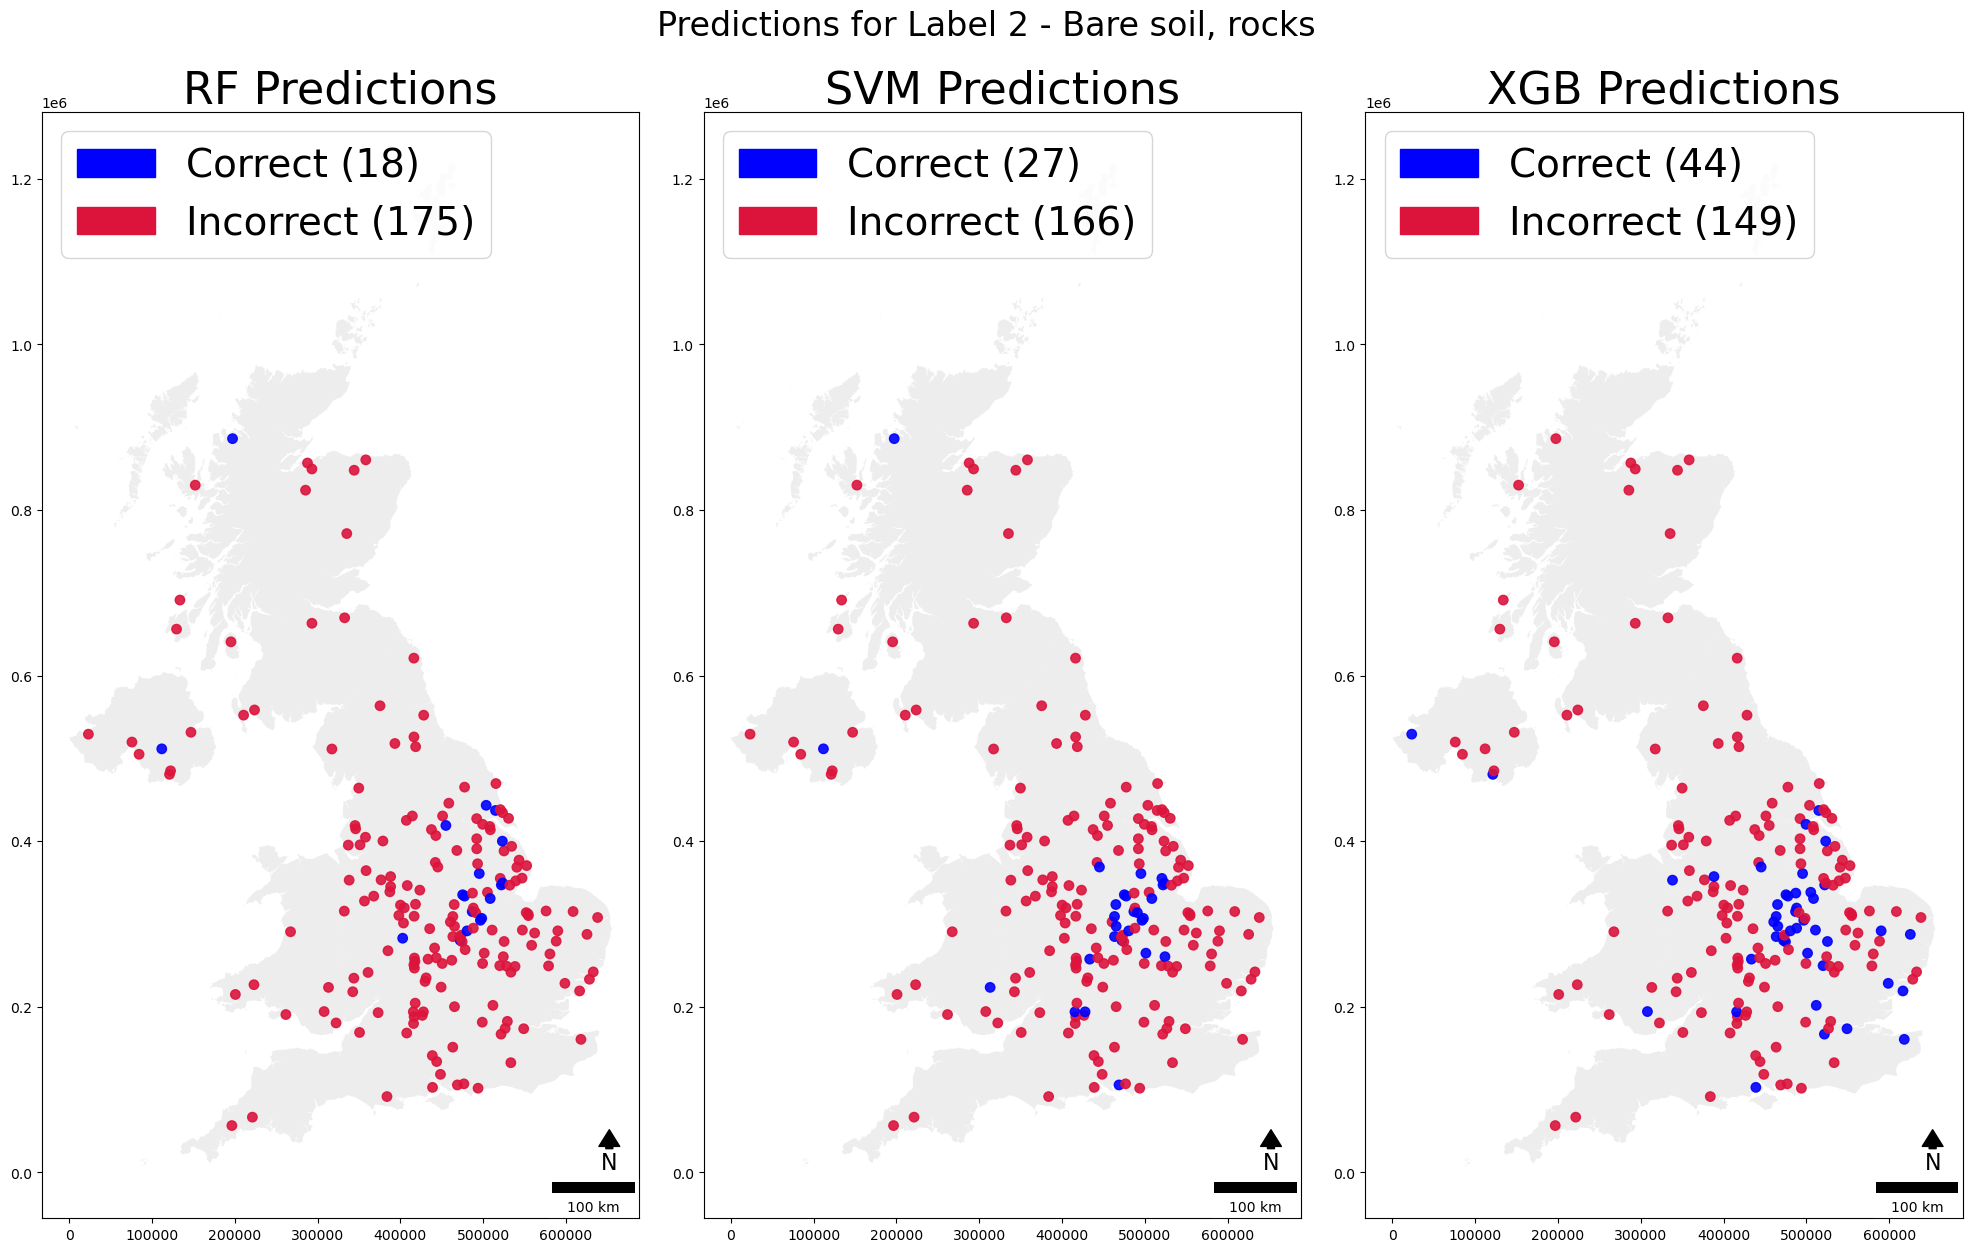

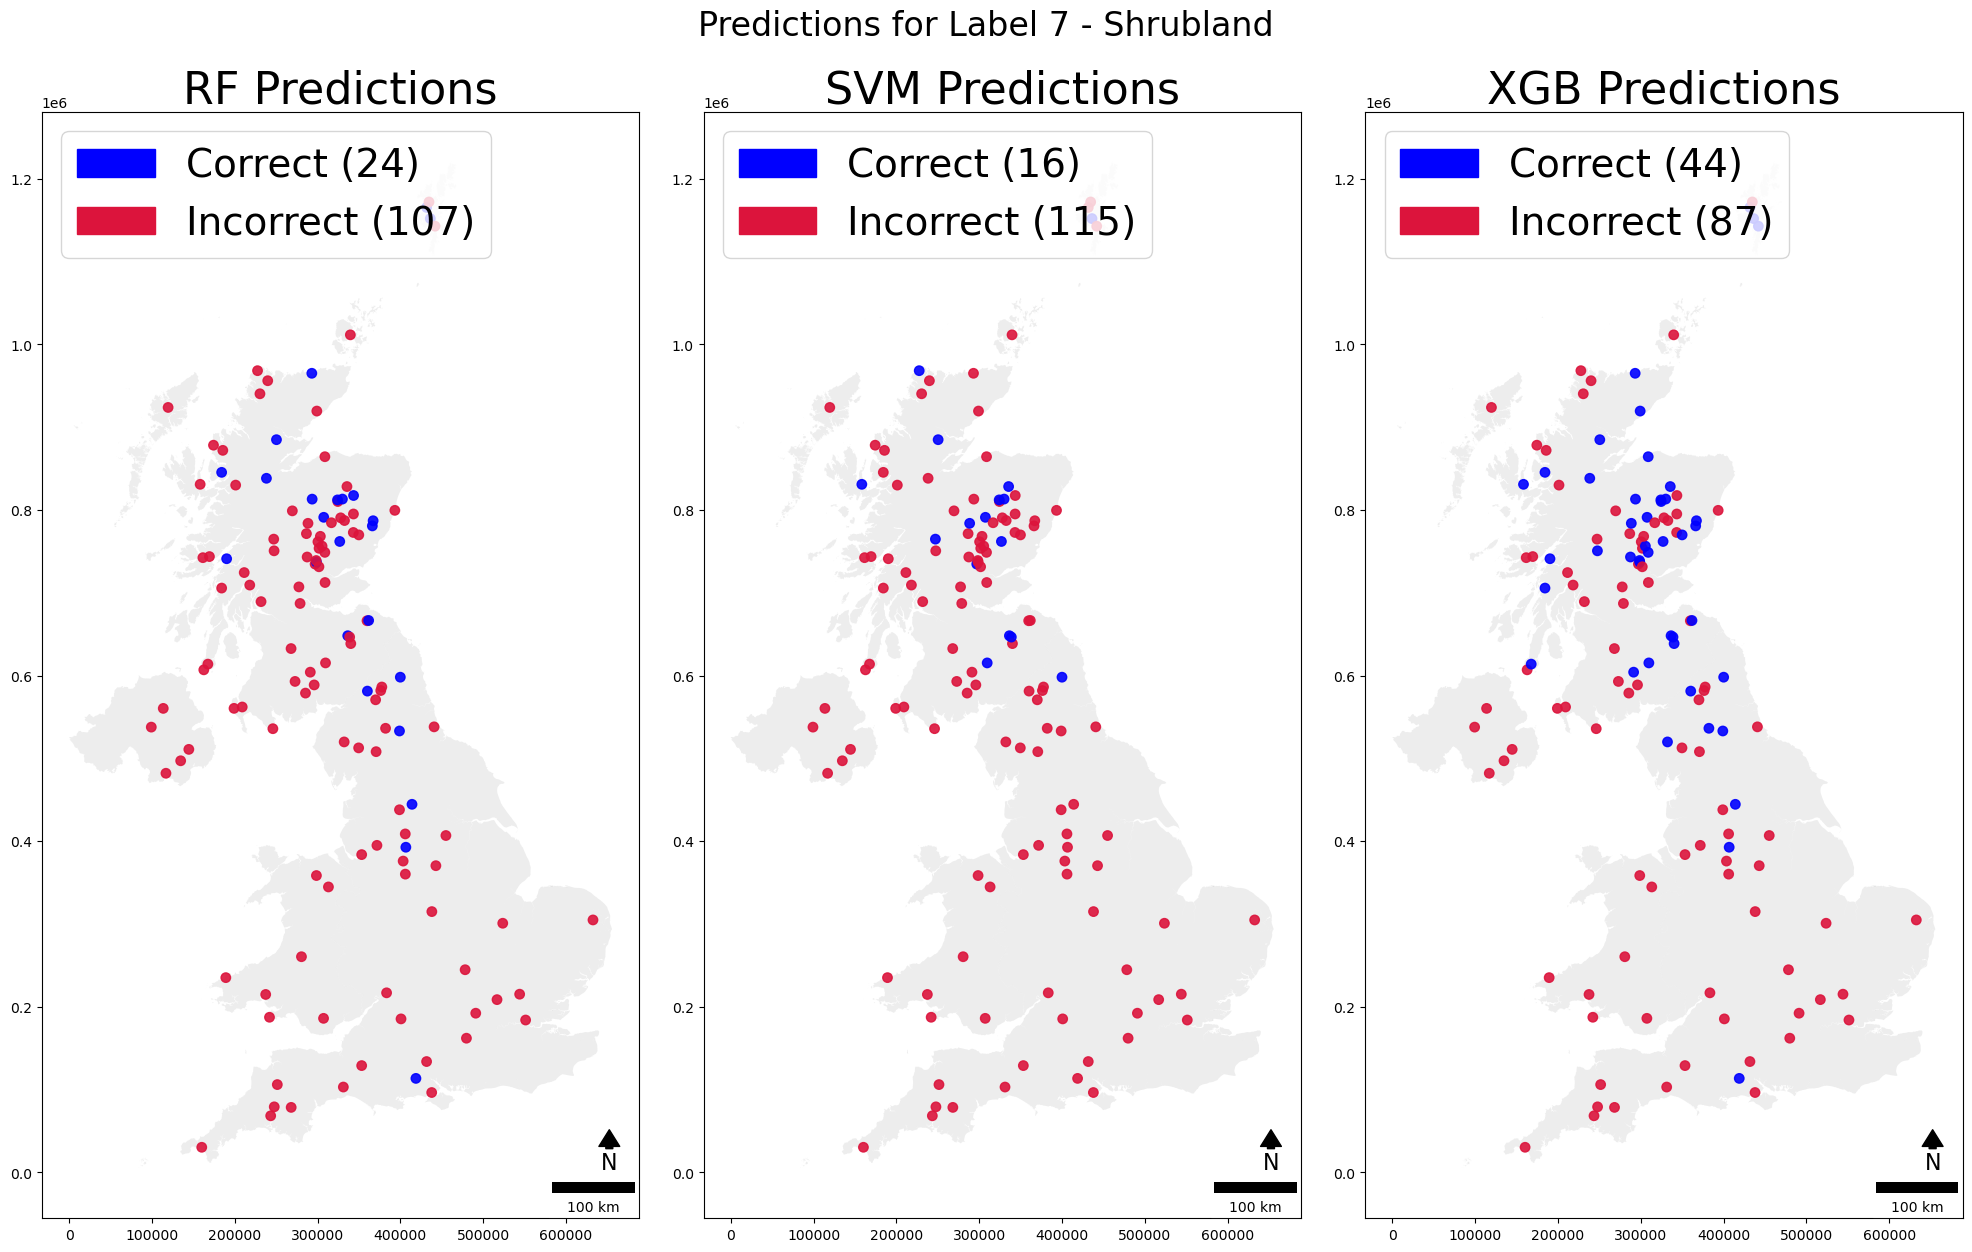

In [54]:
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

# Mapping of label IDs to class names
label_names = {
    2: "Bare soil, rocks",
    7: "Shrubland"
}

# Function to assign colors for each label-specific map
def assign_colors_label(row, model, label):
    try:
        true_label = int(row['True_Label'])
        predicted_label = int(row[f"{model}_Prediction"])
        if true_label == label:
            return "blue" if predicted_label == true_label else "crimson"
        else:
            return "none"
    except (KeyError, ValueError, TypeError):
        return "none"

# Generate map plots for selected labels
for label in [2, 7]:
    fig, axes = plt.subplots(1, 3, figsize=(20, 12))
    fig.suptitle(f"Predictions for Label {label} - {label_names[label]}", fontsize=24, y=1.02)

    for i, model in enumerate(models):
        df_plot = merged_df.copy()
        df_plot["color"] = df_plot.apply(lambda row: assign_colors_label(row, model, label), axis=1)
        df_plot = df_plot[df_plot["color"] != "none"]

        # Convert to GeoDataFrame and reproject
        gdf = gpd.GeoDataFrame(df_plot, geometry=gpd.points_from_xy(df_plot.lon, df_plot.lat), crs="EPSG:4326")
        gdf = gdf.to_crs("EPSG:27700")

        # Count correct and incorrect
        n_correct = (gdf['color'] == 'blue').sum()
        n_incorrect = (gdf['color'] == 'crimson').sum()

        # Plot UK boundary
        uk_boundary.plot(ax=axes[i], facecolor='lightgrey', edgecolor='none', linewidth=0.2, alpha=0.4)

        # Plot prediction points
        gdf.plot(ax=axes[i], color=gdf["color"], markersize=46, alpha=0.9)

        # Updated legend with counts
        correct_patch = mpatches.Patch(color='blue', label=f'Correct ({n_correct})')
        incorrect_patch = mpatches.Patch(color='crimson', label=f'Incorrect ({n_incorrect})')
        axes[i].legend(handles=[correct_patch, incorrect_patch], loc='upper left', fontsize=28)

        # Add Scale Bar (in metres since EPSG:27700 is in meters)
        scalebar = ScaleBar(dx=1, units='m', location='lower right', scale_loc='bottom', box_alpha=0.2, length_fraction=0.15)
        axes[i].add_artist(scalebar)

        # Add North Arrow
        axes[i].annotate('N', xy=(0.95, 0.08), xytext=(0.95, 0.05),
                         arrowprops=dict(facecolor='black', width=5, headwidth=15),
                         ha='center', va='center', fontsize=16,
                         xycoords='axes fraction')

        # Set subplot title
        axes[i].set_title(f"{model} Predictions", fontsize=32)
        #axes[i].set_xlabel("Easting")
        #axes[i].set_ylabel("Northing")

    plt.tight_layout(rect=[0, 0, 1, 0.99])  # Adjust to make space for overall title
    plt.show()
